In [1]:
# https://www.wrighters.io/using-autoreload-to-speed-up-ipython-and-jupyter-work/
%load_ext autoreload
%autoreload 2
#
import torch
from micrograd.tracegraph import draw_dot

In [2]:
# Rebuild the following from micograd_from_scratch_8 in pytorch
## A 2 dimensional neuron with Input x1 and x2
#    x1 = Value(2.0, _label='x1')
#    x2 = Value(0.0, _label='x2')
#    # The Weights
#    w1 = Value(-3.0, _label='w1')
#    w2 = Value(1.0, _label='w2')
#    # The Bias
#    b = Value(6.8813735870195432, _label='b')

# Tensor are n-dimensional arrays of scalar values
# As these are leaf nodes, one has to explicitely say they require grads
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)
# data same name as in micrograd
# o.data is still expected to give 0.7071
print(o.data.item())
print("---")
o.backward()
# grad same name as in micrograd
# x1.grad is still expected to give -1.5
print("x1 grad", x1.grad.item())
# w1.grad is still expected to give 1
print("w1 grad", w1.grad.item())
# x2.grad is still expected to give 0.5
print("x2 grad", x2.grad.item())
# w2.grad is still expected to give 0.0
print("w2 grad", w2.grad.item())

0.7071066904050358
---
x1 grad -1.5000003851533106
w1 grad 1.0000002567688737
x2 grad 0.5000001283844369
w2 grad 0.0


In [3]:
# A 2 by 3 array
t = torch.Tensor([[1, 2, 3], [4, 5, 6]])
print(t)
# print that it is a 2 by 3 array
print(t.shape)
t = torch.Tensor([2.0])
print(t)
# single precision float
print(t.dtype)
# cast for double precision float
t = t.double();
print(t.dtype)

tensor([[1., 2., 3.],
        [4., 5., 6.]])
torch.Size([2, 3])
tensor([2.])
torch.float32
torch.float64


topo: [Value(data=-0.9792560249322666, grad=0, op=prim, label=L0|N0|b), Value(data=-0.15398817440730705, grad=0, op=prim, label=L0|N0|w0), Value(data=2.0, grad=0, op=prim, label=L0|N0|i0), Value(data=-0.3079763488146141, grad=0, op=*, label=?), Value(data=-1.2872323737468807, grad=0, op=+, label=?), Value(data=-0.622528864111974, grad=0, op=prim, label=L0|N0|w1), Value(data=3.0, grad=0, op=prim, label=L0|N0|i1), Value(data=-1.8675865923359218, grad=0, op=*, label=?), Value(data=-3.1548189660828028, grad=0, op=+, label=?), Value(data=-0.9963692200495363, grad=0, op=tanh, label=L0|N0|o)]
leafNodes: [Value(data=3.0, grad=0, op=prim, label=L0|N0|i1), Value(data=-0.622528864111974, grad=0, op=prim, label=L0|N0|w1), Value(data=2.0, grad=0, op=prim, label=L0|N0|i0), Value(data=-0.15398817440730705, grad=0, op=prim, label=L0|N0|w0), Value(data=-0.9792560249322666, grad=0, op=prim, label=L0|N0|b)]


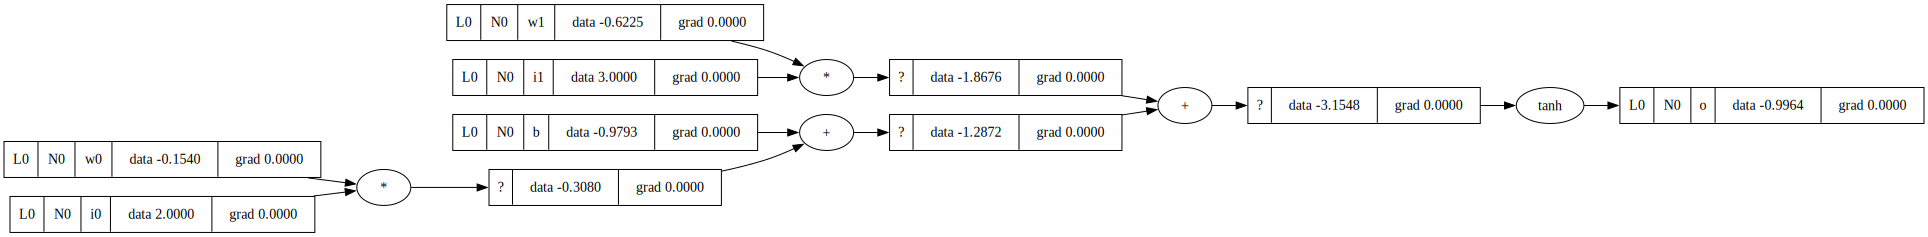

In [4]:
from micrograd.engine import Value
from micrograd.topo import build, findLeafNodes
import random

class Neuron:
    def __init__(self, nin, relLayerIdx, relNeuronIdx):
        """
        nin: number of inputs; how many weights; the data will be provided in the __call__
        relLayerIdx: index of the Layer this Neuron belongs to, relative inside it's MLP
        relNeuronIdx: index of the Neuron relative inside it's Layer
        """
        self.w = [Value(random.uniform(-1,1), _label=f'L{relLayerIdx}|N{relNeuronIdx}|w{_}') for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        self.b._label = f'L{relLayerIdx}|N{relNeuronIdx}|b'

    def __call__(self, xs):
        """
        xs: array of data for the inputs
        return: the out Value of this Neuron
        """
        # convert any x that is not an instance of Value into a Value ...
        xs = [x if isinstance(x, Value) else Value(x) for x in xs]
        # ... so a proper label can be given to it
        for idx, x in enumerate(xs):
            if(len(x._terms)):
                x._label = f'{self.b._label[0:len(self.b._label)-2]}|oi{idx}'
            else:
                x._label = f'{self.b._label[0:len(self.b._label)-2]}|i{idx}'
        # Multiply all the elements of w with the elemnts of x pairweise
        # Therefore we zip up the values of w with x; creates tuples and gives back an iterator
        # We sum them up and add the bias, giving the activation value
        # act = sum(wi * xi for wi,xi in zip(self.w, x))) + self.b
        # Optimize
        act = sum((wi * xi for wi,xi in zip(self.w, xs)), self.b)
        # Then we need to pass that through a non-linear function
        out = act.tanh()
        out._label = f'{self.b._label[0:len(self.b._label)-2]}|o'
        return out

# a Neuron with two inputs, belongs to Layer L0, is named N0
n_1 = Neuron(2, 0, 0)
x_1 = [2.0, 3.0]
# this neuron is provided with data 2.0 und 3.0. Will trigger __call__
out_1 = n_1(x_1)
# build topo and print
topo_out_1 = build(out_1)
print(f'topo: {topo_out_1}')
# find lead nodes in topo and print
leafNodes_out_1 = findLeafNodes(topo_out_1)
print(f'leafNodes: {leafNodes_out_1}')
draw_dot(out_1)

In [5]:
class Layer:
    def __init__(self, nin, nout, relLayerIdx):
        """
        nin: number of inputs; number of weights
        nout: number of outputs; how many Neurons in that layer, each initialized with nin
        relLayerIdx: index of the Layer, relative inside it's MLP
        """
        self.neuron = [Neuron(nin, relLayerIdx, _) for _ in range(nout)]

    def __call__(self, xs):
        """
        xs: array of data for the inputs
        return: array of the out Value of this Layer
        """
        # KNOW
        # The Input primitive values are replicated for each application to the Layer 0.
        # Per the Karpathy's micrograd implementation, there is no Layer for the Input.
        # WANT ?
        # Input primitive values to have an identity. So convert any x that is not an instance of 
        # Value into a Value. To enable, uncomment the next line.
        # xs = [x if isinstance(x, Value) else Value(x) for x in xs]
        #
        outs = [n(xs) for n in self.neuron]
        # for convenience, if outs is just an array with a single element, then return the element
        return outs[0] if len(outs) == 1 else outs
    

In [6]:
# a Layer of 3 Neurons with 2 inputs each is named L0
l_2 = Layer(2,3,0)
x_2 = [2.0, 3.0]
out_2 = l_2(x_2)
print(out_2)

[Value(data=0.9360364378160643, grad=0, op=tanh, label=L0|N0|o), Value(data=0.857355106142619, grad=0, op=tanh, label=L0|N1|o), Value(data=-0.9990335713671139, grad=0, op=tanh, label=L0|N2|o)]


In [7]:
class MLP:
    """
    M(ulti)L(evel)P(erceptron)
    """
    def __init__(self, nin, lnout):
        """
        nin: number of inputs of the first layer
        lnout: list of numbers of outputs in each layer; how many Neurons in each layer
        """
        # [nin, nouts0, nouts1, ...]
        sz = [nin] + lnout
        # The outs of the previous layer are the ins of the current layer 
        # [Layer[nin, nouts0], Layer[nouts0, nouts1], Layer[nouts1, ...]
        self.layers = [Layer(sz[i], sz[i+1], i) for i in range(len(lnout))]

    def __call__(self, xs):
        """
        xs: array of data for the inputs for each layer
        return: array of the out Values of the last layer
        Each array of the out Values of the previous layer is forwarded to the next layer.
        Note that the Input primitive values are replicated for each application to the Layer 0.
        """
        # KNOW
        # The Input primitive values are replicated for each application to the Layer 0.
        # Per the Karpathy's micrograd implementation, there is no Layer for the Input.
        # WANT ?
        # Input primitive values to have an identity. So convert any x that is not an instance of 
        # Value into a Value. To enable, uncomment the next line.
        # xs = [x if isinstance(x, Value) else Value(x) for x in xs]
        #
        outs = xs
        for layer in self.layers:
            outs = layer(outs) 
        return outs

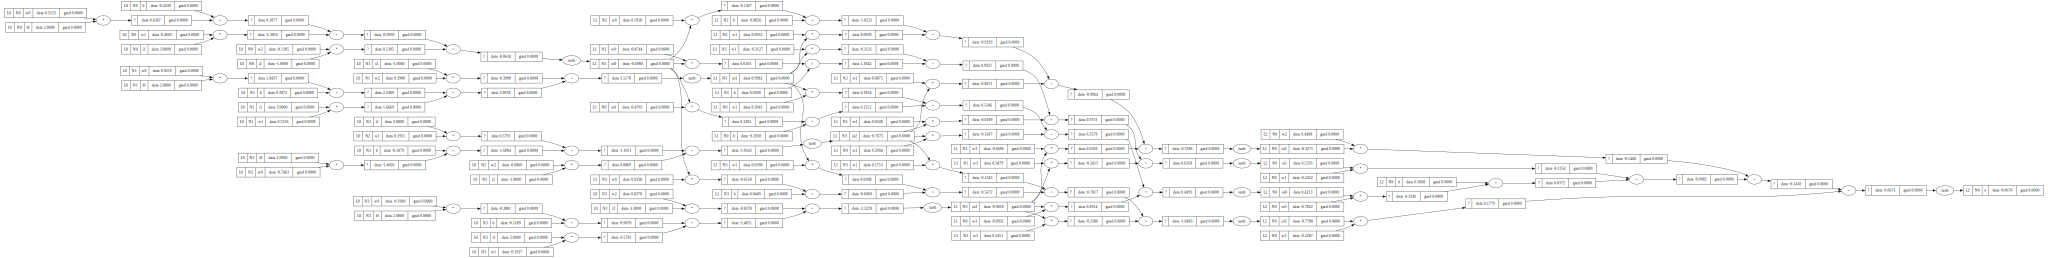

In [8]:
# Now we model doc/neural_net2.jpeg(nn2). 3 input Neurons and 2 layers with 4 Neurons and 1 output Layer with 1 Neuron.
#
# Define the number of input Neurons(1st parameter), then the number inside the 2 Layers, then the number of the 
# output Neuron(to teh array of the 2nd parameter)
mlp_nn2 = MLP(3, [4, 4, 1])
# Define values to the 3 input Neurons
x_nn2 = [2.0, 3.0, -1.0]
# Feed the values of the 3 input Neurons to the MLP
mlp_nn2_out = mlp_nn2(x_nn2)
draw_dot(mlp_nn2_out)